In [61]:
# import torch
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader


# ROOT_DATA_PATH = 'E:\\Programming\\Per\\Python\\Uni_Projects\\Neural_Networks\\mnist_project\\data'

# # Define a transform to normalize the data
# transform = transforms.Compose([
#     transforms.ToTensor(),  # Converts PIL Image or numpy.ndarray to a torch.FloatTensor
#     transforms.Normalize((0.5,), (0.5,))
# ])

# # Download and load the training set
# batch_size = 64

# train_dataset = datasets.MNIST(root=ROOT_DATA_PATH, train=True, transform=transform, download=True)
# train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# # Similarly, you can download and load the test set
# test_dataset = datasets.MNIST(root=ROOT_DATA_PATH, train=False, transform=transform, download=True)
# test_dataloader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [62]:
# # len(train_dataset), train_dataset.classes
# import matplotlib.pyplot as plt

# images, labels = next(iter(train_dataloader))
# image = images[0].view(1, 28, 28)
# label = labels[0].item()
# # print(label)
# image = image.permute(1, 2, 0)
# # image = image * 0.5 + 0.5
# # plt.imshow(image);
# # plt.title(f'label : '+str(label));

In [63]:
#model
from torch import nn

class MLP(nn.Module):
    def __init__(self, in_features, num_classes, list_hidden_features_size):
        super().__init__()
        # self.num_hidden_layer = num_hidden_layer

        self.input_layer = nn.Linear(in_features, list_hidden_features_size[0])
        
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(list_hidden_features_size[i], list_hidden_features_size[i+1]) for i in range(len(list_hidden_features_size)-1)]
        )

        self.out_layer = nn.Linear(list_hidden_features_size[-1], num_classes)

    def forward(self, x):
        x = torch.relu(self.input_layer(x)) 
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))

        x = self.out_layer(x)
        
        return x

In [ ]:
# from torchinfo import summary

# X, y = next(iter(train_dataloader))
# print(X.shape)

# in_feat = X.shape[-1] * X.shape[-1]
# hiddens = [32, 20, 15]
# model = MLP(in_features=in_feat, num_classes=10, list_hidden_features_size=hiddens)


# print(X.shape)
# X = X.view(batch_size, -1)
# print(X.shape)

# out = model(X)
# out.shape


In [ ]:
# import torch.onnx

# # Specify input size
# model = model.to('cpu')
# dummy_input = image.to('cpu')

# # Export the model to ONNX
# onnx_path = 'E:\\dynamic_linear_model.onnx'
# torch.onnx.export(model, dummy_input, onnx_path, verbose=True)

In [103]:
#Train and test 
def one_step_train(model, train_dataloader, loss_fn, optimizer, device):
    model = model.to(device)

    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X.view(X.size(0), -1))
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += ((y_pred_class == y).sum().item())/len(y_pred)

    train_loss = train_loss/len(train_dataloader)
    train_acc = train_acc/len(train_dataloader)

    return train_loss, train_acc

def one_step_test(model, test_dataloader, loss_fn, device):
    model = model.to(device)

    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():

        for batch, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device), y.to(device)

            y_pred = model(X.view(X.size(0), -1))
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += ((y_pred_class == y).sum().item())/len(y_pred)

        test_loss = test_loss/len(test_dataloader)
        test_acc = test_acc/len(test_dataloader)

    return test_loss, test_acc
        

In [9]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset
from torchinfo import summary

from going_modular.model import MLP
from going_modular.utils import plot_loss_curves
from going_modular import engine

# from going_modular.data_setup import train_dataset, train_dataloader, test_dataloader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

hiddens = [64, 32, 16]
model = MLP(in_features=784, num_classes=10, list_hidden_features_size=hiddens)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.0001)

In [11]:
# summary(model, input_size=(64, 784))

In [12]:
# from tqdm.auto import tqdm

# def train(model,
#           train_dataloader,
#           test_dataloader,
#           loss_fn,
#           optimizer,
#           device,
#           epochs):
    
#     results = {
#             'train_loss':[],
#             'train_acc':[],
#             'test_loss':[],
#             'test_acc':[]
#         }
    
#     for epoch in tqdm(range(epochs)):

#         train_loss, train_acc = one_step_train(model,
#                                                 train_dataloader,
#                                                 loss_fn, optimizer,
#                                                 device)

#         test_loss, test_acc = one_step_test(model,
#                                             test_dataloader,
#                                             loss_fn,
#                                             device)

#         results['train_loss'].append(train_loss)
#         results['train_acc'].append(train_acc)
#         results['test_loss'].append(test_loss)
#         results['test_acc'].append(test_acc)

#         print(
#           f"Epoch: {epoch+1} | "
#           f"train_loss: {train_loss:.4f} | "
#           f"train_acc: {train_acc:.4f} | "
#           f"test_loss: {test_loss:.4f} | "
#           f"test_acc: {test_acc:.4f}"
#         )
        
#     return results



Epoch: 1 | train_loss: 2.3148 | train_acc: 0.0978 | test_loss: 2.3084 | test_acc: 0.1151
Epoch: 2 | train_loss: 2.2810 | train_acc: 0.1531 | test_loss: 2.2407 | test_acc: 0.1436


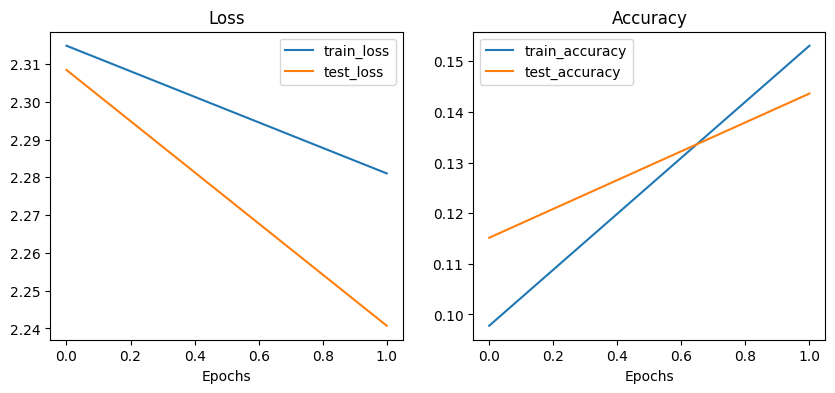

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

hiddens = [64, 32, 32, 32, 32, 16]
model = MLP(in_features=784, num_classes=10, list_hidden_features_size=hiddens)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=.00001)

results = engine.train(model=model,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      device=device,
      epochs=2)

plot_loss_curves(results=results)

In [144]:
# def plot_loss_curves(results):

#     loss = results["train_loss"]
#     test_loss = results["test_loss"]

#     accuracy = results["train_acc"]
#     test_accuracy = results["test_acc"]

#     epochs = range(len(results["train_loss"]))

#     plt.figure(figsize=(10, 4))

#     # Plot loss
#     plt.subplot(1, 2, 1)
#     plt.plot(epochs, loss, label="train_loss")
#     plt.plot(epochs, test_loss, label="test_loss")
#     plt.title("Loss")
#     plt.xlabel("Epochs")
#     plt.legend()

#     # Plot accuracy
#     plt.subplot(1, 2, 2)
#     plt.plot(epochs, accuracy, label="train_accuracy")
#     plt.plot(epochs, test_accuracy, label="test_accuracy")
#     plt.title("Accuracy")
#     plt.xlabel("Epochs")
#     plt.legend()

In [ ]:
# plot_loss_curves(results=results)

In [158]:
y = train_dataset.targets
dataset_indices = list(range(len(train_dataset)))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

batch_size = 64

kfold_tests_results = []
for fold, (train_index, val_index) in enumerate(skf.split(dataset_indices, y)):
    
    train_dataset_fold = Subset(train_dataset, train_index)
    train_loader = DataLoader(train_dataset_fold, batch_size=batch_size, shuffle=True, num_workers=2)

    valid_dataset_fold = Subset(train_dataset, val_index)
    valid_loader = DataLoader(valid_dataset_fold, batch_size=batch_size, shuffle=True, num_workers=2)

    results_each_fold = engine.train(model=model, 
                                        train_dataloader=train_loader,
                                        test_dataloader=test_dataloader,
                                        loss_fn=loss_fn, 
                                        optimizer=optimizer, 
                                        device=device,
                                        epochs=1)
    #return last test_acc 
    last_test_acc = kfold_tests_results.append(results_each_fold['test_acc'][-1]) 

print(f'test_accs is :{kfold_tests_results}')
print(f'test_acc mean for our model is :{sum(kfold_tests_results)/len(kfold_tests_results)}')

100%|██████████| 1/1 [00:13<00:00, 13.99s/it]


Epoch: 1 | train_loss: 0.8467 | train_acc: 0.7747 | test_loss: 0.8081 | test_acc: 0.7823


  0%|          | 0/1 [00:03<?, ?it/s]


KeyboardInterrupt: 